In [1]:
%matplotlib inline
from scipy import misc
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import data

# HOG
HOG特征输入为128*64的灰度图像，一个block由2*2个cell组成，一个cell由8*8个pixel组成，将一个cell用直方图(bins=9，[0,20,40,60,80,100,120,140,160])表示，那么一个block由2*2*9共36长度的向量表示。

---
## 参考链接

[Histogram of Oriented Gradients](https://www.learnopencv.com/histogram-of-oriented-gradients/)

[方向梯度直方图](https://zh.wikipedia.org/wiki/%E6%96%B9%E5%90%91%E6%A2%AF%E5%BA%A6%E7%9B%B4%E6%96%B9%E5%9B%BE)

[图像特征提取之HOG特征](https://senitco.github.io/2017/06/10/image-feature-hog/)

[80行Python实现-HOG梯度特征提取](https://pengzhaoqing.github.io/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89/hog/)

[histogram.py](https://github.com/JeanKossaifi/python-hog/blob/master/hog/histogram.py)

[hog.py](https://github.com/PENGZhaoqing/Hog-feature/blob/master/hog.py)

[hog.py](https://github.com/holtzhau/scikits.image/blob/master/skimage/feature/hog.py)

In [2]:
# np.atleast_2d?
# np.diff?
# np.arctan2?
# np.where?

np.diff(a, n=1, axis=-1) along the given axis diff

In [3]:
img = cv2.imread('../data/lena.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32)
# img = misc.imresize(img, (128, 64))
# img = data.astronaut()
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img = img.astype(np.float32)
height, width = img.shape

In [4]:
img.shape

(512, 512)

In [5]:
img.dtype

dtype('float32')

# 计算一阶图像梯度
$$g_x=I(x,y)-I(x-1,y)$$
$$g_y=I(x,y)-I(x,y-1)$$

In [6]:
# gx = np.zeros_like(img)
# gy = np.zeros_like(img)
# gx[:, 1:] = np.diff(img, n=1, axis=1) # 第二维度进行差分，其中第一个元素为0
# gy[1:, :] = np.diff(img, n=1, axis=0) # 第二维度进行差分，其中第一个元素为0

In [7]:
gx = cv2.Sobel(img, -1, dx=1, dy=0, ksize=1)
gy = cv2.Sobel(img, -1, dx=0, dy=1, ksize=1)

In [8]:
magnitude = np.sqrt(gx**2+gy**2)
orientation = np.arctan2(gy, gx) * 180 / np.pi

In [9]:
orientation_bins = 9 # 方向直方图bin为9
cell_size = 8
block_size = 16

In [10]:
# 一个cell的
def cell_gradient(cell_magnitude, cell_angle, orientation_bins=9):
    orientation_centers = [0] * orientation_bins
    angle_unit = 180 / orientation_bins # angle_unit=20
    for k in range(cell_magnitude.shape[0]):
        for l in range(cell_magnitude.shape[1]):
            # 每一个cell的梯度大小和方向
            gradient_strength = cell_magnitude[k][l]
            gradient_angle = cell_angle[k][l]
            # 设置梯度方向区间为0-180
            if gradient_angle<0:
                gradient_angle = 180+gradient_angle
            gradient_angle = int(gradient_angle)
            min_angle = int(gradient_angle / angle_unit) % orientation_bins
            max_angle = (min_angle + 1) % orientation_bins
            mod = gradient_angle % angle_unit # 防止角度刚好在中间，均分幅值
            orientation_centers[min_angle] += int(gradient_strength * (1 - (mod * 1.0 / angle_unit)))
            orientation_centers[max_angle] += int(gradient_strength * (mod *1.0 / angle_unit))
    return orientation_centers

In [11]:
cell_gradient_vector = np.zeros((height/cell_size, width/cell_size, orientation_bins))

In [12]:
cell_gradient_vector.shape

(64, 64, 9)

In [13]:
for i in range(cell_gradient_vector.shape[0]):
    for j in range(cell_gradient_vector.shape[1]):
        # 获取每一个cell的梯度幅值和方向
        cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size,
                         j * cell_size:(j + 1) * cell_size]
        cell_angle = orientation[i * cell_size:(i + 1) * cell_size,
                     j * cell_size:(j + 1) * cell_size]

        cell_gradient_vector[i][j] = cell_gradient(cell_magnitude, cell_angle)

In [14]:
cell_gradient_vector[0, 0, :]

array([53., 25., 15., 13., 26.,  9., 10.,  1.,  2.])

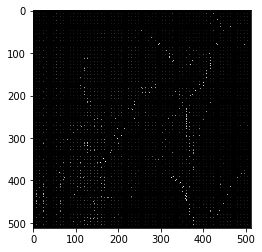

In [15]:
hog_image= np.zeros([height, width])
cell_width = cell_size / 2
max_mag = np.array(cell_gradient_vector).max()
angle_unit = 180 / orientation_bins
for x in range(cell_gradient_vector.shape[0]):
    for y in range(cell_gradient_vector.shape[1]):
        cell_grad = cell_gradient_vector[x][y]
        cell_grad /= max_mag
        angle = 0
        angle_gap = angle_unit
        for mag in cell_grad:
            angle_radian = math.radians(angle)
            x1 = int(x * cell_size + mag * cell_width * math.cos(angle_radian))
            y1 = int(y * cell_size + mag * cell_width * math.sin(angle_radian))
            x2 = int(x * cell_size - mag * cell_width * math.cos(angle_radian))
            y2 = int(y * cell_size - mag * cell_width * math.sin(angle_radian))
            cv2.line(hog_image, (y1, x1), (y2, x2), int(255 * math.sqrt(mag)))
            angle += angle_gap
plt.imshow(hog_image, cmap='gray')

In [16]:
hog_vector = []
for i in range(cell_gradient_vector.shape[0] - 1):
    for j in range(cell_gradient_vector.shape[1] - 1):
        block_vector = []
        block_vector.extend(cell_gradient_vector[i][j])
        block_vector.extend(cell_gradient_vector[i][j + 1])
        block_vector.extend(cell_gradient_vector[i + 1][j])
        block_vector.extend(cell_gradient_vector[i + 1][j + 1])
        mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
        mag_norm_val = mag(block_vector)
        if mag_norm_val != 0:
            normalize = lambda block_vector, mag_norm_val: [element / mag_norm_val for element in block_vector]
            block_vector = normalize(block_vector, mag_norm_val)
        hog_vector.append(block_vector)
hog_vector = np.array(hog_vector)
hog_vector = hog_vector.reshape(-1, 1)
print('hog_vector.shape:', hog_vector.shape)

('hog_vector.shape:', (142884, 1))


In [17]:
hog_vector

array([[0.33061778],
       [0.15595178],
       [0.09357107],
       ...,
       [0.04677296],
       [0.02728423],
       [0.05067071]])